# Heart attack prediction

## Install dependencies

In [1]:
!pip install -U gdown numpy pandas scikit-learn seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.9-py2.py3-none-any.whl/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
Requirement already up-to-date: gdown in /home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages (4.5.1)
/usr/share/python-wheels/urllib3-1.25.9-py2.py3-none-any.whl/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
Requirement already up-to-date: numpy in /home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homewo

## Download data

In [2]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c
To: /home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/HW1/MaciejPióro/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 4.52MB/s]


'heart.csv'

## Load & Preprocess data
Categorical variables: `cp` and `restecg`. All models used (Logistic Regression, Decision Tree, Random Forest) can benefit from one-hot encoding the categorical variables

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 997
TEST_SIZE = 0.1

data = pd.read_csv('heart.csv')

In [4]:
def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['output'])
y = data['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

## Train & evaluate the models

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def check_model_quality(model_name, y_test, y_pred):
  print("Quality with", model_name)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"- Accuracy score: {accuracy:.2f}")
  f1 = f1_score(y_test, y_pred)
  print(f"- F1 score: {f1:.2f}")
  precision = precision_score(y_test, y_pred)
  print(f"- Precision: {precision:.2f}")
  recall = recall_score(y_test, y_pred)
  print(f"- Recall: {recall:.2f}")
  print()
  return accuracy, f1, precision, recall

metrics = pd.DataFrame(columns=['Accuracy', 'F1', 'Precision', 'Recall'])

In [7]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(random_state=SEED, max_iter=10_000)
logistic_regression.fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)
acc, f1, pr, rc = check_model_quality('Logistic Regression', y_test, y_pred)
metrics.loc['Logistic Regression'] = [acc, f1, pr, rc]

Quality with Logistic Regression
- Accuracy score: 0.77
- F1 score: 0.84
- Precision: 0.78
- Recall: 0.90



In [8]:
from sklearn.tree import DecisionTreeClassifier


tree_classifier = DecisionTreeClassifier(random_state=SEED)
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict(X_test)
acc, f1, pr, rc = check_model_quality('Decision Tree Classifier', y_test, y_pred)
metrics.loc['Decision Tree'] = [acc, f1, pr, rc]

Quality with Decision Tree Classifier
- Accuracy score: 0.84
- F1 score: 0.88
- Precision: 0.86
- Recall: 0.90



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer


forest_classifier = RandomForestClassifier(random_state=SEED)
forest_classifier.fit(X_train, y_train)


y_pred = forest_classifier.predict(X_test)
acc, f1, pr, rc = check_model_quality('Random Forest Classifier', y_test, y_pred)
metrics.loc['Random Forest'] = [acc, f1, pr, rc]

Quality with Random Forest Classifier
- Accuracy score: 0.90
- F1 score: 0.93
- Precision: 0.90
- Recall: 0.95



## Results and conclusions

Random Forest improves Decision Classifier, which is better than simple Logistic Regression. The same trend is visible in all relevant chosen metrics (Accuracy, F1, Precision, Recall).

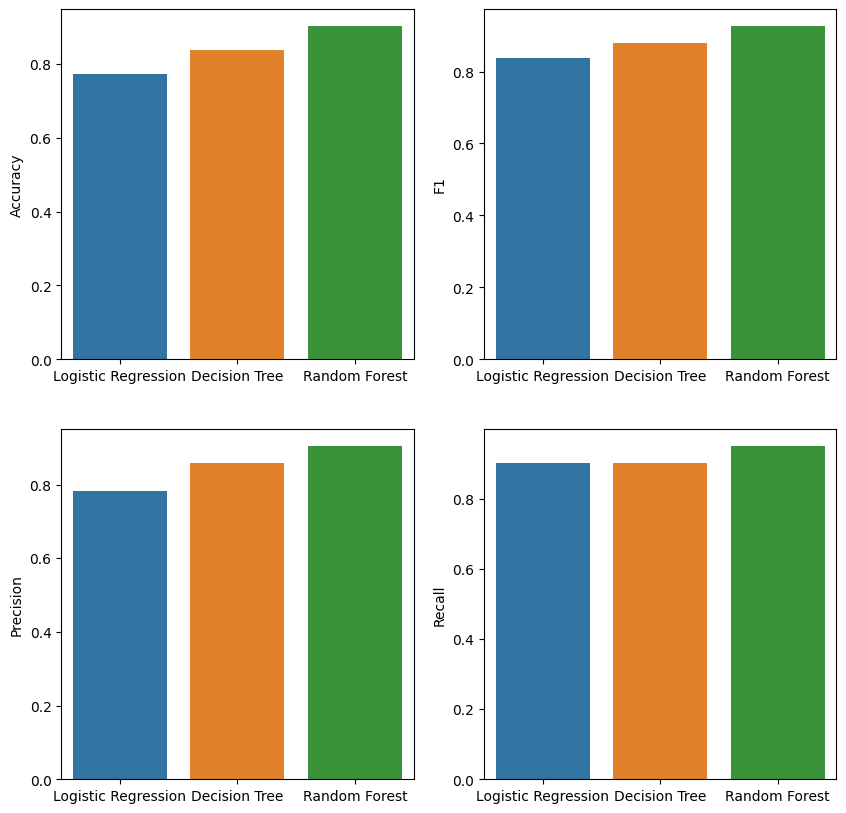

In [10]:
from IPython.display import display

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for m, ax in zip(['Accuracy', 'F1', 'Precision', 'Recall'], ([0, 0], [0, 1], [1, 0], [1, 1])): 
    sns.barplot(x = metrics.index, y = metrics[m], ax=axes[ax[0], ax[1]])